In [1]:
import os

from dateutil.parser import parse
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from src.od.ODModel import OutlierDetectionModel

unix_date_scaler = preprocessing.MinMaxScaler()

In [2]:
_action_index = 0
_name_index = 1
_user_index = 2
_date_index = 3
_test_file_server_name = 'test_file_server'
_data_amount_per_line = 4

In [3]:
# Load data
data = {}

data_path = '../git-test/data'
for file in tqdm(os.listdir(data_path)):
    with open(f'{data_path}/{file}', 'r') as f:
        def preprocess(line):
            line = line.replace('\n', '')
            return line.split(',')
        data[file] = list(
            filter(
                lambda split_line: len(split_line) == _data_amount_per_line,
                map(preprocess, f.readlines())
            )
        )

  0%|          | 0/114 [00:00<?, ?it/s]

In [ ]:
len(data)

In [5]:
data_amount = list(map(lambda kv: (kv[0], len(kv[1])), data.items()))
" ".join(list(map(str, data_amount)))

"('20180926-095306', 578) ('20181007-084939', 85) ('20181015-102630', 281) ('20181023-105006', 306) ('20181031-105133', 591) ('20181108-110859', 442) ('20181116-123840', 618) ('20181125-175842', 834) ('20181204-105813', 616) ('20181212-110443', 759) ('20181220-111348', 357) ('20181228-111947', 293) ('20190105-184058', 199) ('20190113-203303', 1289) ('20190121-214717', 111) ('20190130-105845', 48) ('20190207-113418', 65) ('20190215-134957', 632) ('20190225-151829', 674) ('20190306-115254', 1754) ('20190314-115358', 467) ('20190322-145756', 673) ('20190330-163307', 2168) ('20190407-165754', 1617) ('20190415-181758', 580) ('20190424-072953', 722) ('20190502-100007', 708) ('20190510-184141', 248) ('20190518-232137', 274) ('20190527-091224', 2284) ('20190604-101832', 1228) ('20190612-113444', 818) ('20190620-170009', 659) ('20190628-170304', 1303) ('20190706-214137', 974) ('20190714-224723', 589) ('20190723-103129', 318) ('20190731-104444', 1136) ('20190808-105016', 1034) ('20190816-115442'

<BarContainer object of 114 artists>

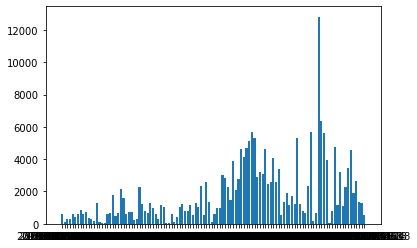

In [6]:
labels, counts = zip(*data_amount)
plt.bar(labels, counts)

In [7]:
for k in sorted(data.keys())[:2]:
    print(data[k])

[['A', '.DS_Store', 'cambolbro', '20180918-104510'], ['A', '.gitignore', 'cambolbro', '20180918-104510'], ['A', 'AI/.classpath', 'cambolbro', '20180918-104510'], ['A', 'AI/.gitignore', 'cambolbro', '20180918-104510'], ['A', 'AI/.project', 'cambolbro', '20180918-104510'], ['A', 'AI/.settings/org.eclipse.jdt.core.prefs', 'cambolbro', '20180918-104510'], ['A', 'AI/src/main/AI.java', 'cambolbro', '20180918-104510'], ['A', 'Common/.classpath', 'cambolbro', '20180918-104510'], ['A', 'Common/.gitignore', 'cambolbro', '20180918-104510'], ['A', 'Common/.project', 'cambolbro', '20180918-104510'], ['A', 'Common/.settings/org.eclipse.jdt.core.prefs', 'cambolbro', '20180918-104510'], ['A', 'Common/src/.DS_Store', 'cambolbro', '20180918-104510'], ['A', 'Common/src/annotations/Anon.java', 'cambolbro', '20180918-104510'], ['A', 'Common/src/annotations/Name.java', 'cambolbro', '20180918-104510'], ['A', 'Common/src/annotations/Opt.java', 'cambolbro', '20180918-104510'], ['A', 'Common/src/main/BitTwiddli

In [8]:
from src.loader.database.MongoDBConnector import MongoDBConnector, create_example_server

db = MongoDBConnector()
db.reset_data()
create_example_server(db)

{'con': 'example connection',
 'check_schedule': 2,
 'name': 'test_file_server',
 '_id': ObjectId('617be8dbf913baaed1c0b5f2')}

In [9]:
from src.loader.FileDatabase import FileDatabase


def get_backup_meta_data(backed_up_files):
    backed_up_amount = len(backed_up_files)

    # Get the actions and counts of each action
    action_list = list(map(lambda d: d[_action_index], backed_up_files))
    uniques, counts = np.unique(action_list, return_counts = True)

    # Get the mean and std deviation of the min max scaled date range of all changes
    parse_access_dates = list(map(lambda d: parse(d[_date_index]), backed_up_files))
    unix_dates = np.array(list(map(lambda date: time.mktime(date.timetuple()), parse_access_dates)))
    unix_dates = unix_dates.reshape(-1, 1)
    unix_dates_scaled = unix_date_scaler.fit_transform(unix_dates)

    unix_dates_mean = np.mean(unix_dates_scaled)
    unix_dates_std = np.std(unix_dates_scaled)

    # Get the date ranges in unix time stamps
    sorted_access_dates = sorted(unix_dates)
    earliest_date = sorted_access_dates[0]
    latest_date = sorted_access_dates[-1]
    return dict(
        backed_up_amount = backed_up_amount,
        uniques_counts = dict(uniques = uniques.tolist(), counts = counts.tolist()),
        date_range = dict(earliest_date = earliest_date.item(), latest_date = latest_date.item()),
        date_mean_std = dict(unix_dates_mean = unix_dates_mean, unix_dates_std = unix_dates_std)
    )

# get_backup_meta_data(data['20180926-095306'])

file_database = []

def calc_moving_avg(old_avg, new_value, count):
    return old_avg * (count - 1) / count + new_value * count

def parse_feature_data(backed_up_files, file_database):
    backup_meta_data = get_backup_meta_data(backed_up_files)

    current_file_database = FileDatabase(file_database, is_sorted = True)

    file_features = []

    for file_data in backed_up_files:
        file_name = file_data[1]

        action, name, user, date = file_data

        # Check if the file is in the database
        if file_name not in current_file_database:

            # Create a new entry in the file feature vector
            file_features.append(dict(
                name = name,
                action_date = date,
                action = action,
                user = user,
                user_difference = 0,
                frequency = 0,
                amount = 0,
                time_since_last_use = 0,
            ))
        else:
            # create a file vector based
            file_history = current_file_database.get_file_history(name)

            # Get the meta data over the file history
            amount = len(file_history)
            current_date = parse(date)
            time_since_last_use = parse(file_history[-1]['action_date']) - current_date
            date_range = parse(file_history[0]['action_date']) - current_date

            user_difference = 0 if file_history[-1]['user'] == user else 1

            file_features.append(dict(
                name = name,
                action_date = date,
                action = action,
                user = user,
                user_difference = user_difference,
                frequency = amount / date_range.total_seconds(),
                amount = amount,
                time_since_last_use = time_since_last_use.total_seconds(),
            ))

    return file_features, backup_meta_data

def vectorize(file_features, backup_meta_data):
    # Path length
    # Creation date?
    pass

def report_result(result):
    pass


def get_file_database(file_server, db):
    as_list = db.get_file_data_as_list(file_server['_id'])
    return as_list


def store_file_features(file_features, backup_meta_data, current_file_server):
    current_file_server_id = current_file_server['_id']

    added_meta_data = db.add_backup_meta_data(
        file_server_id = current_file_server_id,
        meta_data = backup_meta_data,
    )
    backup_data_id = added_meta_data.inserted_id

    db.add_file_data(
        file_server_id = current_file_server_id,
        backup_data_id = backup_data_id,
        file_data_list = file_features
    )


for backup_date in tqdm(sorted(data.keys())):
    backed_up_files = data[backup_date]

    current_file_server = db.get_file_server_by_name(_test_file_server_name)

    file_database = get_file_database(current_file_server, db)

    file_features, backup_meta_data = parse_feature_data(backed_up_files, file_database)
    vectorization = vectorize(file_features, backup_meta_data)

    store_file_features(file_features, backup_meta_data, current_file_server)

    # Model specific data
    model = load_file_server_model(file_server = current_file_server)
    result = model.outlier_detection(vectorization)
    model.fit_on_new_data(vectorization)
    model.update_db_model()

    report_result(result)

  0%|          | 0/114 [00:00<?, ?it/s]